In [49]:
import timeit
import time
from pathlib import Path
import random
import sys
import re
sys.path.append(str(Path.cwd().parent / "classes"))
sys.path.append(str(Path.cwd().parent))



import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats

from sim_config import SimConfiguration
from simulation import Simulation
from msa import Msa


numbers = re.compile(r"\d+\.\d+")


TREES_PATH = Path.cwd() / "chiroptera_data"

In [50]:
def refresh_sim(tree_file):
    seed = time.time_ns()%1000000
    random.seed(seed)
    tree_path = Path(tree_file)

    fasta_path = (tree_path.parent / (tree_path.stem + ".fasta")).resolve()
    fasta_text = fasta_path.read_text().replace("-","")
    fasta_seqs = fasta_text.split(">")[1:]
    sequences_length = [len(seq.replace("\n","")) for seq in fasta_seqs]

    min_seq_len = int(min(sequences_length) *0.8)
    max_seq_len = int(max(sequences_length) *1.1)

    ROOT_SEQUENCE_LENGTH = random.randint(min_seq_len, max_seq_len)

    indel_rate = random.uniform(0.0001, 0.05)
    length_param_alpha = random.uniform(1.01, 2.0)
    print("seed=", seed, "indel_rate=",indel_rate, "Root length=", ROOT_SEQUENCE_LENGTH)

    sim_config = SimConfiguration(original_sequence_length=ROOT_SEQUENCE_LENGTH, indel_length_alpha=length_param_alpha,
                                indel_truncated_length=50,
                                rate_ins=indel_rate, rate_del=indel_rate,
                                deletion_extra_edge_length=50,
                                switch_factor=200,
                                seed=seed)
    sim = Simulation(input_tree=str(tree_file), config=sim_config)
    return sim

In [58]:
time_log = {"blocklist": [],
            "naive": [],
            "dataset": [],
            "total_branches": [],
            "average_root": []
            }

for tree in TREES_PATH.iterdir():
    if tree.suffix == ".fasta":
        continue
    print(tree.stem)
    times_of_list, times_of_naive = [], []
    root_lengths = []
    for i in range(5):
        current_sim = refresh_sim(str(tree))
        root_lengths.append(current_sim.sim_nodes[1].length_of_sequence_before)

        blocklist_time = timeit.timeit(current_sim.msa_from_blocklist, number=1)
        times_of_list.append(blocklist_time)
        print("Blocklist time","is", blocklist_time, "sec")
        
        naive_time = timeit.timeit(current_sim.msa_from_naive, number=1)
        print("Naive_time","is", naive_time, "sec")
        times_of_naive.append(naive_time)
    time_log["blocklist"].append(np.mean(times_of_list))
    time_log["naive"].append(np.mean(times_of_naive))
    time_log["dataset"].append(tree.stem)

    tree_text = tree.read_text()
    sum_of_branches = sum(map(float, numbers.findall(tree_text)))
    time_log["total_branches"].append(sum_of_branches)
    time_log["average_root"].append(np.mean(root_lengths))


401934_NT_AL_AA
seed= 77142 indel_rate= 0.002040921514561846 Root length= 217
217
Blocklist time is 0.007753499000045849 sec
Naive_time is 0.010590784999749303 sec
seed= 850398 indel_rate= 0.045759625439961926 Root length= 228
228
Blocklist time is 0.00843057099973521 sec
Naive_time is 0.012502798999776132 sec
seed= 633399 indel_rate= 0.040522052212683776 Root length= 190
190
Blocklist time is 0.002662920999682683 sec
Naive_time is 0.006956831000024977 sec
seed= 845554 indel_rate= 0.028778118860206616 Root length= 332
332
Blocklist time is 0.004334891999860702 sec
Naive_time is 0.015255329999945388 sec
seed= 699824 indel_rate= 0.025230500364312954 Root length= 303
303
Blocklist time is 0.004136970000217843 sec
Naive_time is 0.019839157000205887 sec
57481_NT_AL_AA
seed= 983696 indel_rate= 0.04129374493017595 Root length= 1632
1632
Blocklist time is 0.027989164000246092 sec
Naive_time is 0.3859526090000145 sec
seed= 561099 indel_rate= 0.022939255799380942 Root length= 2132
2132
Blocklist

In [59]:
time_log_df = pd.DataFrame(time_log)

In [60]:
time_log_df["time_ratio"] = (time_log_df["naive"]/ time_log_df["blocklist"] )

<Axes: xlabel='total_branches', ylabel='time_ratio'>

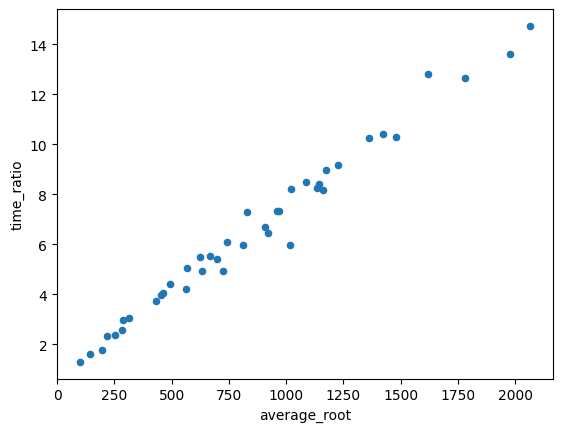

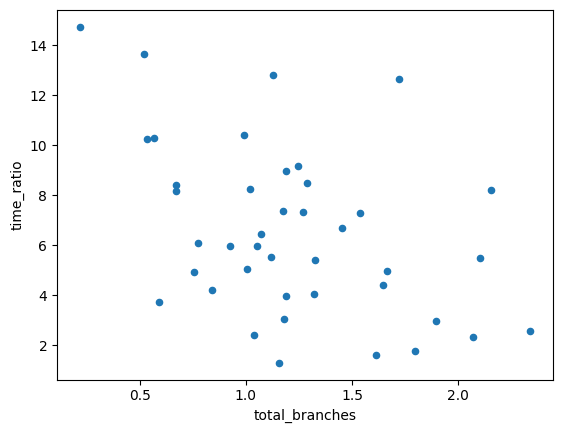

In [ ]:
time_log_df.plot(x="average_root", y="time_ratio", kind="scatter")


In [ ]:
fake_tree = "(A:0.5,(B:11.44535,C:0.0005):0.5);"


numbers.findall(fake_tree)

['0.5', '11.44535', '0.0005', '0.5']